In [1]:
################################################################################
#####################  Xgboost HPO GPU for 2018 - 2019 #########################
################################################################################

In [2]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import joblib
from hyperopt import STATUS_OK
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
from eli5 import show_prediction
import shap

     |████████████████████████████████| 82 kB 236 kB/s 
     |████████████████████████████████| 173.6 MB 6.4 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 564 kB 4.6 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['XgboostGPU_traintrain1819'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('MaritimeTrade_10-19_MLP.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (23259149, 13)


In [7]:
# Subset years for training
df = df.loc[(df['Year']>=2018) & (df['Year']< 2020)]

In [8]:
# Examine distribution of year data
df[['Year']].value_counts()

Year
2018    3080375
2019    2978984
dtype: int64

In [9]:
# Create variables that did not exist preCOVID to match with COVID data
df = df.copy()
df.loc[:,'cases_weekly'] = 0
df.loc[:,'deaths_weekly'] = 0
df.loc[:,'State_Closure_EA_Diff'] = 0
df.loc[:,'cases_pctdelta'] = 0
df.loc[:,'deaths_pctdelta'] = 0

df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('str')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('0','False')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('1','True')

In [10]:
# Reformat for X,y
df2 = df.drop(['Metric_Tons'], axis=1)
df1 = df.loc[:, ['Metric_Tons']]
df = pd.concat([df1, df2], axis=1)

del df1, df2

In [11]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df.iloc[:,:1]

del df

In [12]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify= X.Year,
                                                    random_state = seed_value)

In [13]:
# Training set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_train = ce_ord.fit_transform(X_train)

# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test = ce_ord.fit_transform(X_test)

In [14]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [15]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(mn.fit_transform(X_test), columns = X_test.columns)

In [16]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/

/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results


In [ ]:
################################################################################
######################     Xgboost HPO GPU    ##################################
######################       100 trials       ##################################
################################################################################
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),
    'reg_alpha' : hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight' : hp.choice('min_child_weight', np.arange(0, 10, dtype=int)),
    }

# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """Xgboost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=seed_value,
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                                      scoring='neg_root_mean_squared_error',
                                      cv=kfolds)
    run_time = timer() - start
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    


# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'Xgboost_HPO_train1819_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))


Start Time           2022-02-18 00:28:18.583642
100%|██████████| 100/100 [5:32:07<00:00, 199.27s/it, best loss: 350.7266932530201]
Start Time           2022-02-18 00:28:18.583642
End Time             2022-02-18 06:00:25.641074
5:32:07


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key = lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 350.7266932530201, 'params': {'colsample_bylevel': 0.3378549263629474, 'colsample_bytree': 0.6662531613988424, 'gamma': 0.8483219167001996, 'learning_rate': 0.040743703542436435, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 485, 'reg_alpha': 27, 'reg_lambda': 2.519019242361794, 'subsample': 0.5053571891260848}, 'iteration': 70, 'train_time': 513.3204846110002, 'status': 'ok'}, {'loss': 350.9795631757681, 'params': {'colsample_bylevel': 0.30193748084340205, 'colsample_bytree': 0.8446703029143787, 'gamma': 1.635129876708801, 'learning_rate': 0.07385029741641519, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 249, 'reg_alpha': 8, 'reg_lambda': 2.6630358240486935, 'subsample': 0.545484238488734}, 'iteration': 84, 'train_time': 300.10529975999816, 'status': 'ok'}]


In [17]:
# Access results
results = pd.read_csv('Xgboost_HPO_train1819_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [18]:
# Re-create the best model and train on the training data
best_bayes_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_train1819_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train1819_100_GPU.pkl')
# print(model)
# =============================================================================

In [19]:
print('\nModel Metrics for Xgboost HPO Train train1819 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for Xgboost HPO Train train1819 100 GPU trials
MAE train: 19.136, test: 27.221
MSE train: 73281.531, test: 178586.926
RMSE train: 270.706, test: 422.595
R^2 train: 0.796, test: 0.465


In [20]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 178586.92644 MSE on the test set.
This was achieved after 70 search iterations


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Xgboost_HPO_train1819_100_GPU.csv', 
                    index = False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

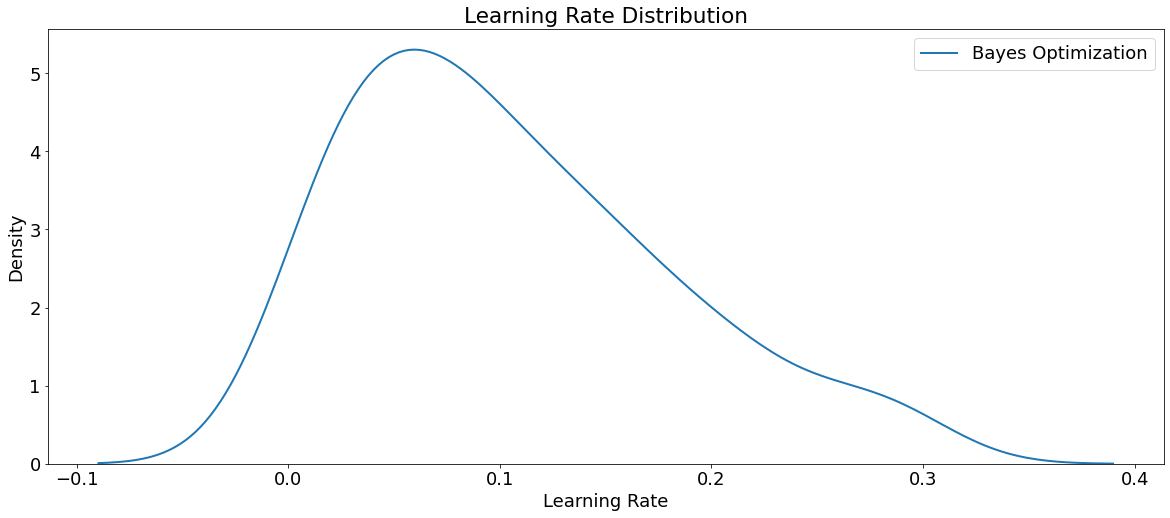

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

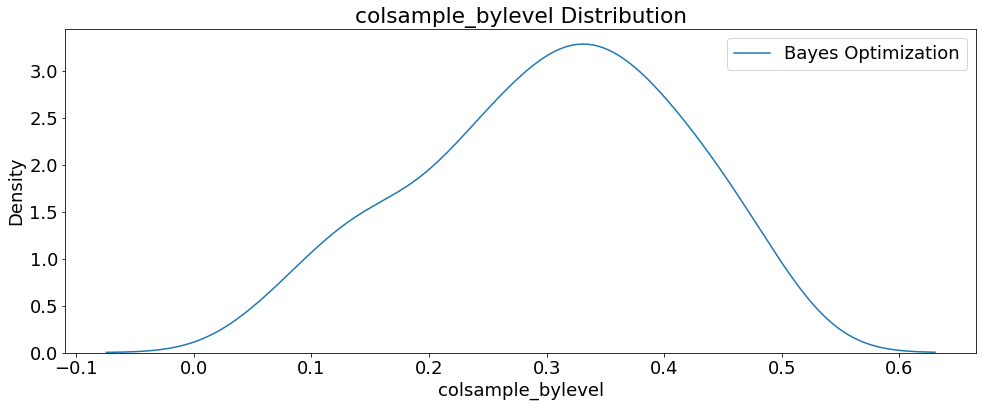

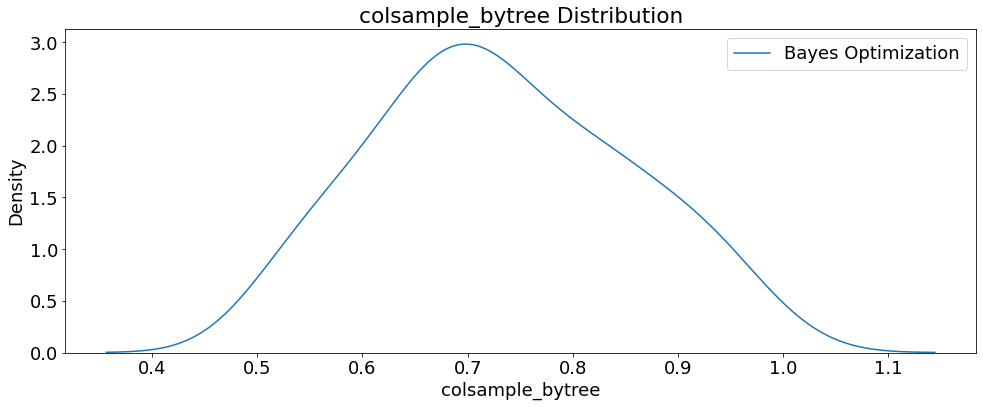

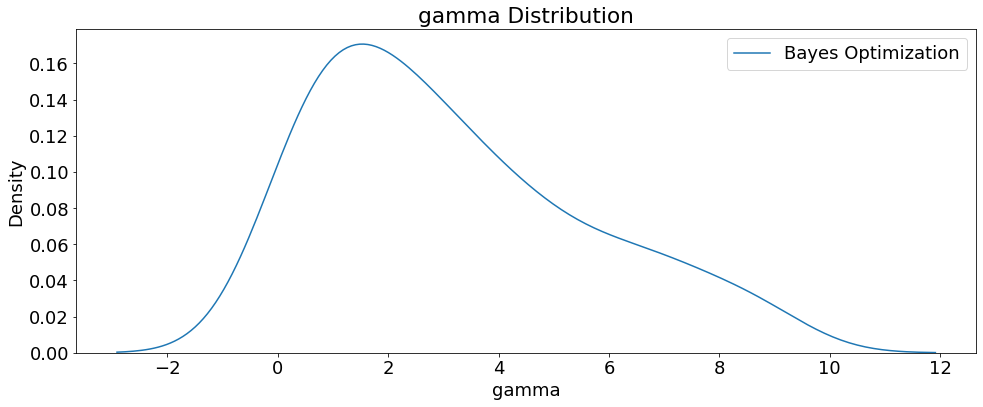

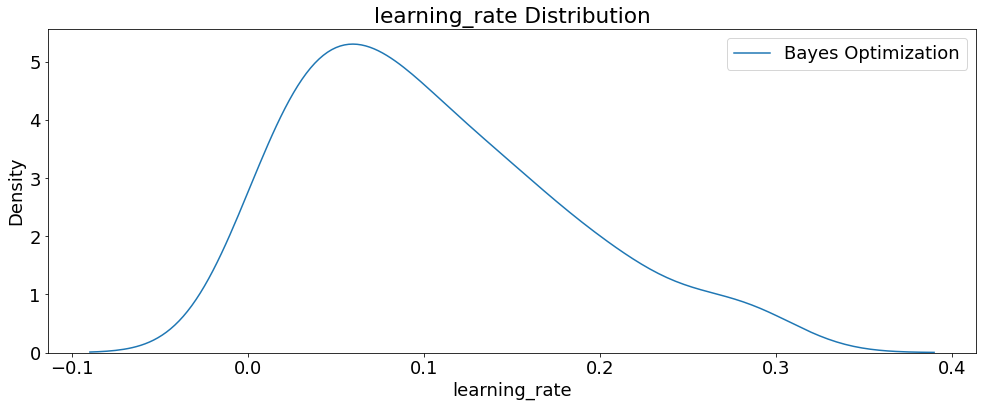

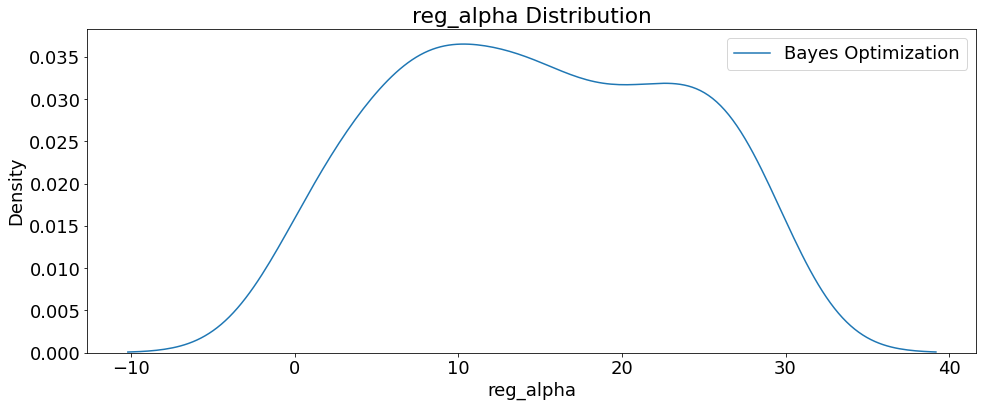

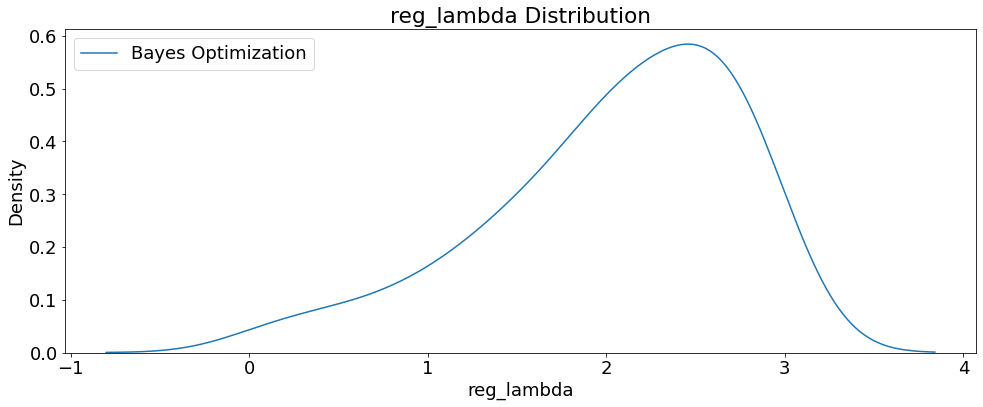

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                     'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

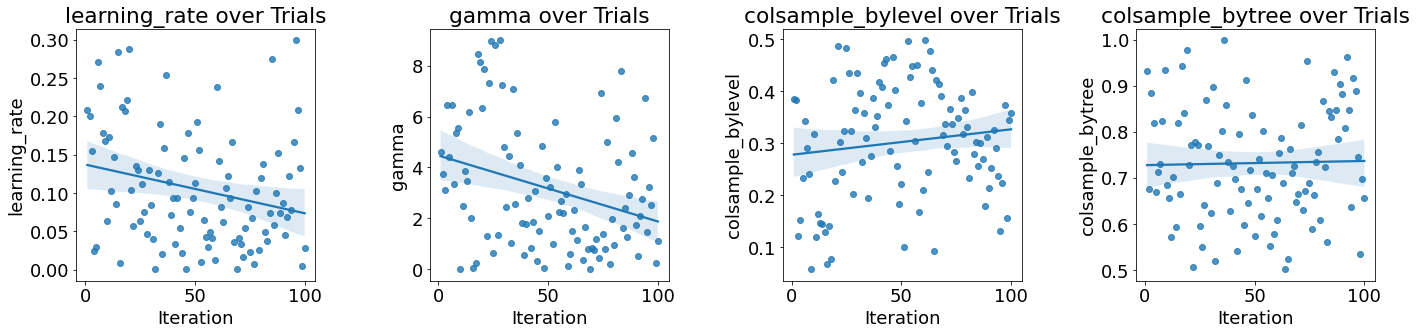

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


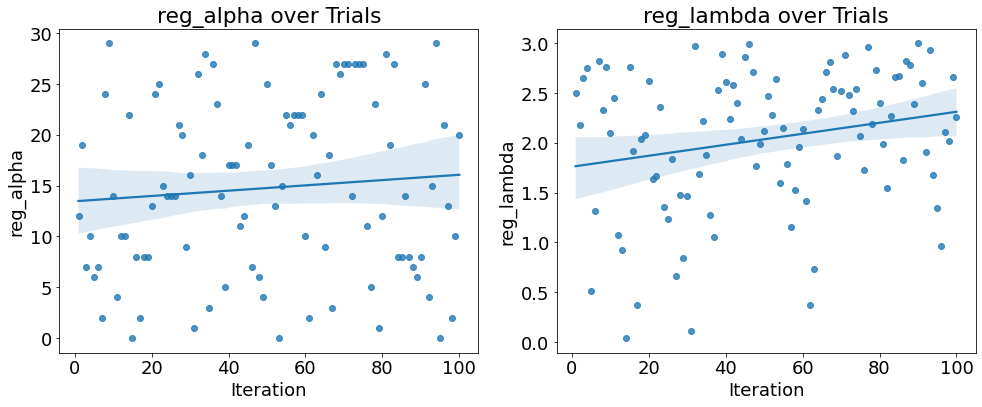

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

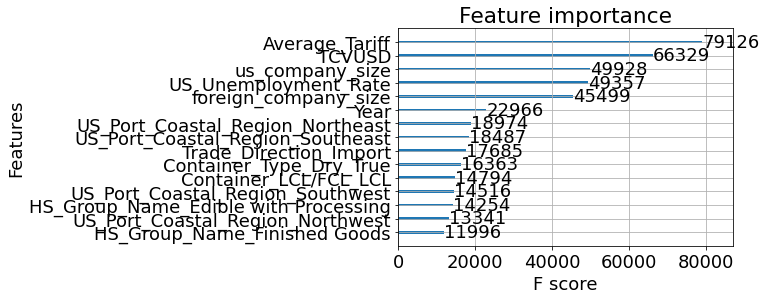

In [ ]:
# Plot the feature importance from best model result
my_dpi=96

plot_importance(best_bayes_model, max_num_features = 15)
plt.savefig('MaritimeTrade_Xgboost_HPO_train1819_100_GPU_FeatureImportance.png',
            dpi=my_dpi * 10, bbox_inches='tight')

In [50]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

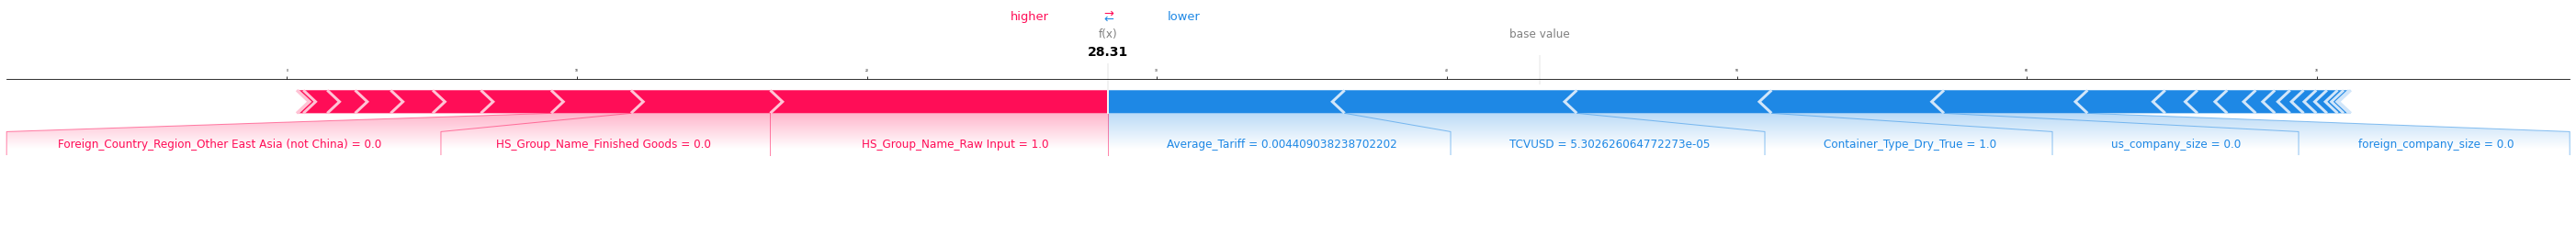

In [51]:
# Visualize the first prediction's explanation
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 3})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(50, 3)).savefig('Xgboost_HPO_100_GPU_train1819test1819_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

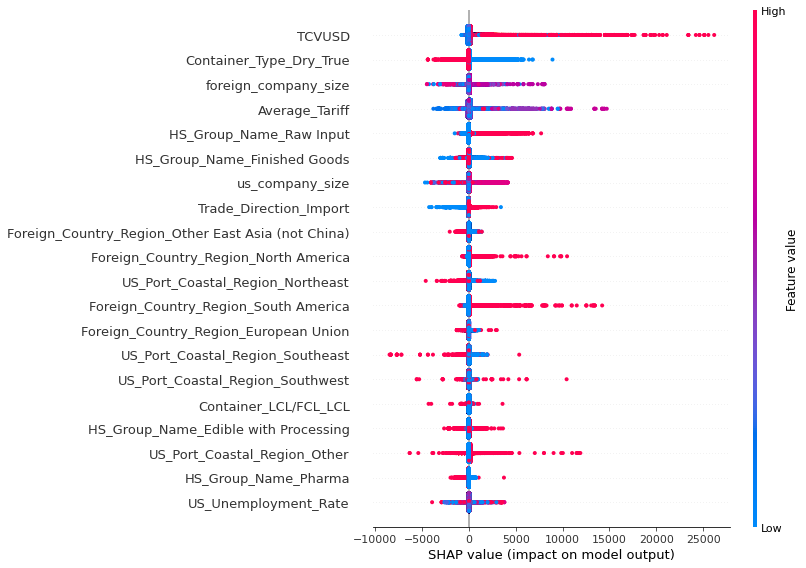

In [24]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('Xgboost_HPO_100_GPU_train1819test1819_ShapSummary_TrainSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [25]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

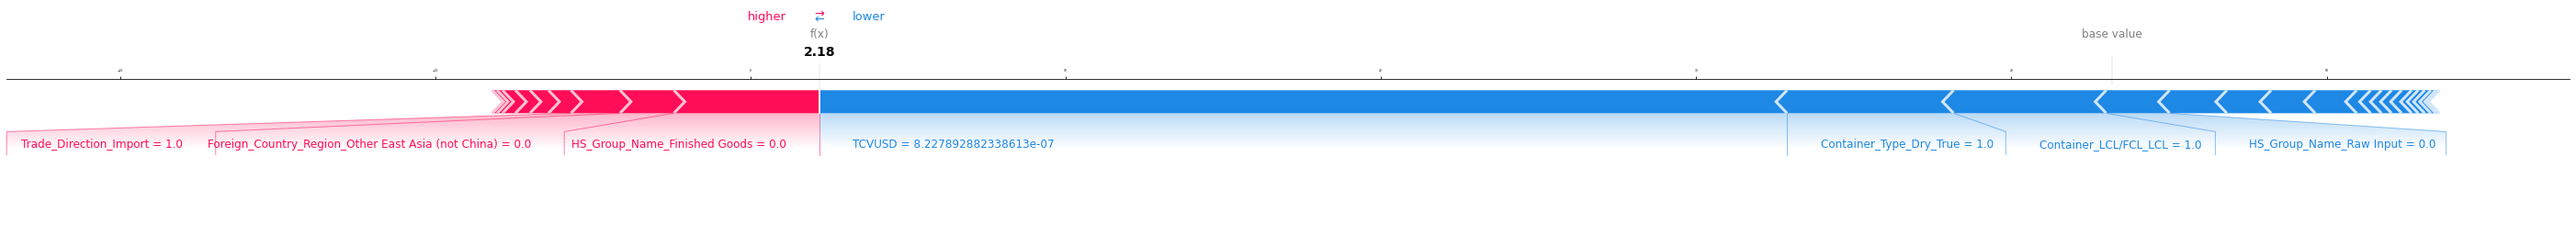

In [30]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 3})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(50, 3)).savefig('Xgboost_HPO_100_GPU_train1819test1819_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

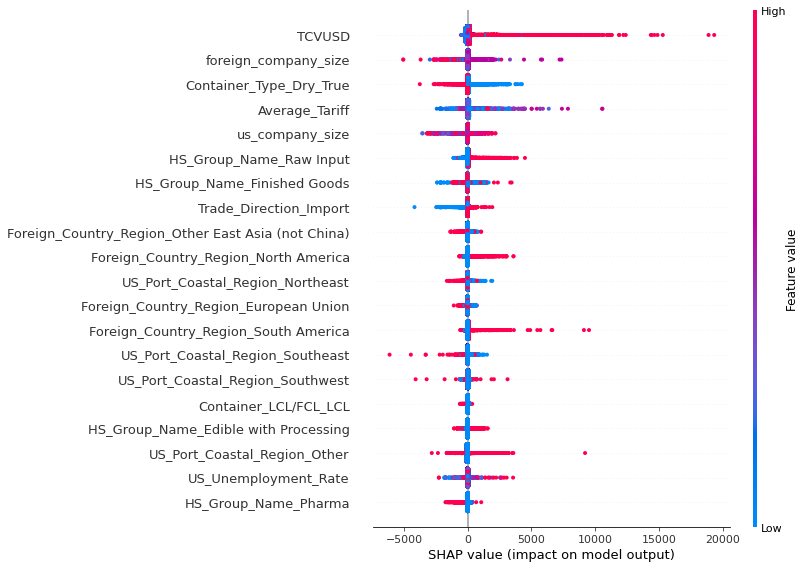

In [27]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('Xgboost_HPO_100_GPU_train1819test1819_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train1819_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train1819_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

Weight,Feature
0.5524 ± 0.0119,TCVUSD
0.2713 ± 0.0203,Average_Tariff
0.1977 ± 0.0188,Container_Type_Dry_True
0.1283 ± 0.0063,HS_Group_Name_Raw Input
0.1238 ± 0.0105,foreign_company_size
0.1139 ± 0.0163,HS_Group_Name_Finished Goods
0.1086 ± 0.0052,Trade_Direction_Import
0.0547 ± 0.0051,Foreign_Country_Region_South America
0.0530 ± 0.0097,US_Port_Coastal_Region_Northwest
0.0390 ± 0.0013,US_Port_Coastal_Region_Other


In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('MaritimeTrade_best_bayes_train1819_HPO_100_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')

del X, y, X_test, y_test

In [31]:
################################################################################
################### Test trained model on 2018-19 on 2020 ######################
################################################################################

In [32]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [33]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6703389, 22)


In [34]:
# Filter df to 2020
df = df[df['Year'] == 2020]

In [35]:
# Drop time and COVID-19 vars
df = df.drop(['State', 'DateTime','DateTime_YearWeek', 'Date_Weekly_COVID'], axis=1)

In [36]:
# Rename to match variable format in 2018-19
df.rename(columns = {'US_company_size': 'us_company_size'}, inplace = True) 

In [37]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [38]:
# Filter missing data
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()]

In [39]:
# Prepare 2020 to fit model train on 2019
X_test1 = df.drop(['Metric_Tons'],axis=1)
y_test1 = df['Metric_Tons']

del df

In [40]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [41]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [42]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns = X_test1.columns)

In [43]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/

/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results


In [44]:
# Re-create the best model and train on the training data
best_bayes_model_20 = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model_20.fit(X_test1, y_test1)

# Save model
Pkl_Filename = 'Xgboost_HPO_train1819_test2020_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train1819_test2020_100_GPU.pkl')
# print(model)
# =============================================================================

In [45]:
# Model Metrics
print('\nModel Metrics for Xgboost HPO Train 2018-19 Test 2020')

y_test_pred = best_bayes_model_20.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for Xgboost HPO Train 2018-19 Test 2020
MAE train: 19.136, test: 5.542
MSE train: 73281.531, test: 133.739
RMSE train: 270.706, test: 11.565
R^2 train: 0.796, test: 0.785


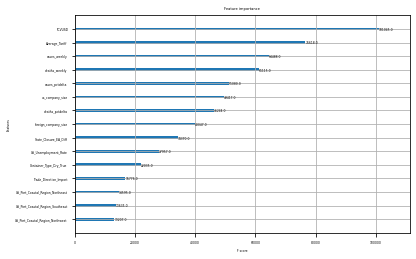

In [46]:
# Plot the feature importance from best model result
my_dpi=96
plot_importance(best_bayes_model_20, max_num_features = 15)
plt.savefig('MaritimeTrade_Xgboost_HPO_train1819test20_100_GPU_FeatureImportance.png',
            dpi=my_dpi * 10, bbox_inches='tight')

In [47]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model_20)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

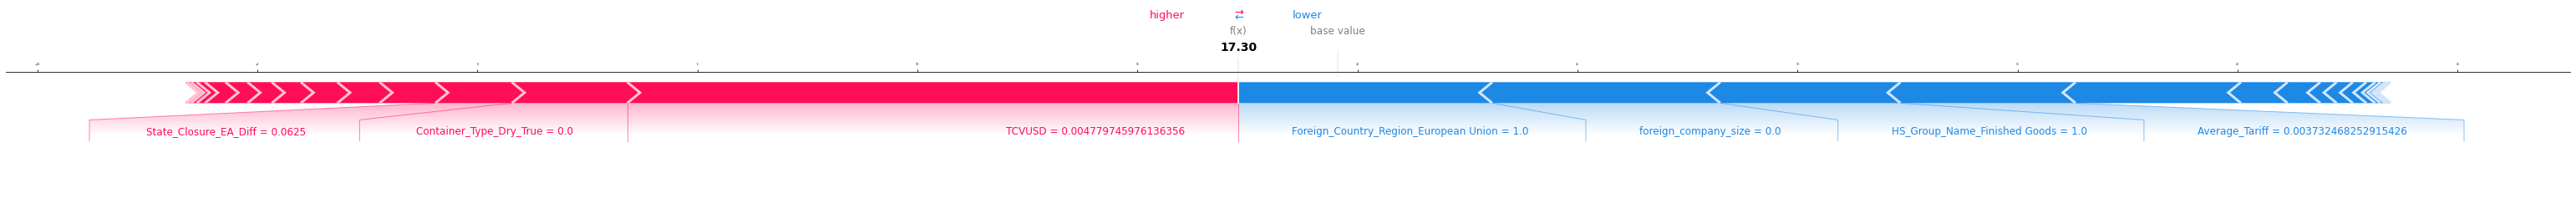

In [48]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 3})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55, 3)).savefig('Xgboost_HPO_100_GPU_train1819test20_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

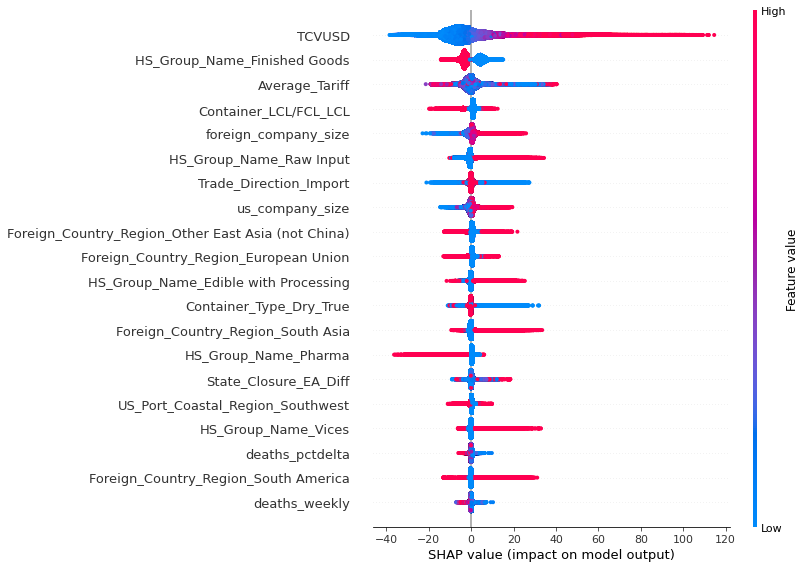

In [49]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('Xgboost_HPO_100_GPU_train1819test20_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model_20,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_train.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train1819test20_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train1819test20_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.9269 ± 0.0009,TCVUSD
0.2816 ± 0.0006,Average_Tariff
0.1155 ± 0.0003,US_Port_Coastal_Region_Southeast
0.1138 ± 0.0005,US_Port_Coastal_Region_Northwest
0.1073 ± 0.0006,Trade_Direction_Import
0.0763 ± 0.0004,us_company_size
0.0751 ± 0.0005,Year
0.0520 ± 0.0006,Container_Type_Dry_True
0.0459 ± 0.0002,US_Port_Coastal_Region_Northeast
0.0394 ± 0.0003,Foreign_Country_Region_Other Europe (not European Union)


In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_train.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('MaritimeTrade_best_bayes_train1819test20_HPO_100_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')